## Multimodal classification

The project is organised along the following structure:
0. Packages import
1. Datasets, dataloaders
2. Image
3. Audio
4. Multimodal classification

We begin by emptying any unwanted gpu usage.

In [1]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=c52dc92d88bb5c04e789498cb56e51c2910b2269a4b7d14c5b14a7b1422a8d18
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 10% |  2% |


# Data import

Here are all the packages that we used in the project.

In [2]:
from __future__ import print_function, division

import torch
import torchvision
import copy
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler

from skimage import io, transform

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# File directory
datadir = '/kaggle/input/iogs-atsi-multimodal'

In [3]:
from matplotlib.ticker import MaxNLocator
def show_curves(acc_dict, loss_dict):
    
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

# 1. Datasets

We create the datasets that we will use in the whole project. These are the train/test full tests.

In [4]:
## train
traindata = pd.read_csv(os.path.join(datadir,'data_train.csv'), delimiter=',', nrows = None)
data = np.array(traindata)
# class and data
y_train = data[:,-1].astype('int32')
audio_train_df = traindata.iloc[:,1:-1]
image_train_df = traindata['IMAGE']

## test
testdata = pd.read_csv(os.path.join(datadir,'data_test_novt.csv'), delimiter=',', nrows = None)
audio_test_df = testdata.iloc[:,1:]
image_test_df = testdata['IMAGE']

nbClass = max(y_train)+1

This class is for formatting the datasets.

In [5]:
class CustomImageAudioDataset(Dataset):
    def __init__(self, target, img_dataset = None, audio_dataset= None, transform=None):
        """
        Args:
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dataset = img_dataset
        self.audio_dataset = audio_dataset
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        target = self.target[idx]
        
        if self.img_dataset is not None:
            img_name = self.img_dataset.iloc[idx]
            image = io.imread(datadir+'/data/data/'+img_name)
            image = torch.Tensor(image)
            if self.transform:
                image = self.transform(image)
            image = image.permute(2,1,0)#.long()
            if self.audio_dataset is None:
                return image,target
            
        if self.audio_dataset is not None:
            audio = self.audio_dataset.iloc[idx]
            audio = torch.Tensor(audio)
            if self.img_dataset is None: 
                return audio,target
            
        return image,audio,target

And this is to create the dataloaders.

In [6]:
def createLoaders(full_train_dataset, batch_size = 4):
# Split dataset
    global dataset_sizes
    dataset_size = len(full_train_dataset)
    val_size = int(0.2*dataset_size)
    train_size = dataset_size-val_size
    dataset_sizes = {'train':train_size, 'val':val_size}

    train_dataset, val_dataset = random_split(
            full_train_dataset,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
    )

    # Create dataloaders
    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True
    )
    valloader   = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=True
    )
    
    return trainloader, valloader

In [7]:
# Create dataset
full_train_dataset = CustomImageAudioDataset(y_train, image_train_df,audio_train_df,)
trainloader, valloader = createLoaders(full_train_dataset)
dataloaders = {'train': trainloader, 'val':valloader}


sample = next(iter(trainloader))[2]
print(sample.shape)

sample = next(iter(valloader))[2]
print(sample.shape)

torch.Size([4])
torch.Size([4])


# 2. Images

We will use transfer learning, with a learning rate of 10^-3 (standard for fine-tuning).

In [8]:
# Instanciate dataset
full_train_dataset = CustomImageAudioDataset(y_train, img_dataset = image_train_df)
trainloader, valloader = createLoaders(full_train_dataset)
dataloaders = {'train': trainloader, 'val':valloader}

sample_target = next(iter(trainloader))[0]
print(sample_target.shape)

torch.Size([4, 3, 256, 256])


In [9]:
model_ft = models.resnet18(pretrained=True) # You need to enable internet
#print(model_ft)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(
    in_features = num_ftrs, 
    out_features = nbClass
)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}
epoch = 0

Epoch 0/9
----------
train Loss: 0.3557 Acc: 0.8875
val Loss: 0.0738 Acc: 0.9732

Epoch 1/9
----------
train Loss: 0.1421 Acc: 0.9568
val Loss: 0.0583 Acc: 0.9779

Epoch 2/9
----------
train Loss: 0.0968 Acc: 0.9715
val Loss: 0.0545 Acc: 0.9873

Epoch 3/9
----------
train Loss: 0.0667 Acc: 0.9815
val Loss: 0.0461 Acc: 0.9844

Epoch 4/9
----------
train Loss: 0.0677 Acc: 0.9807
val Loss: 0.0314 Acc: 0.9920

Epoch 5/9
----------
train Loss: 0.0408 Acc: 0.9889
val Loss: 0.0579 Acc: 0.9837

Epoch 6/9
----------
train Loss: 0.0267 Acc: 0.9939
val Loss: 0.0311 Acc: 0.9913

Epoch 7/9
----------
train Loss: 0.0234 Acc: 0.9939
val Loss: 0.0225 Acc: 0.9938

Epoch 8/9
----------
train Loss: 0.0251 Acc: 0.9949
val Loss: 0.0236 Acc: 0.9924

Epoch 9/9
----------
train Loss: 0.0148 Acc: 0.9962
val Loss: 0.0337 Acc: 0.9899

Best val Acc: 0.993841


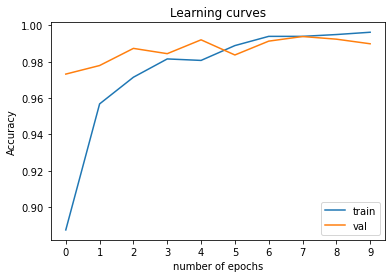

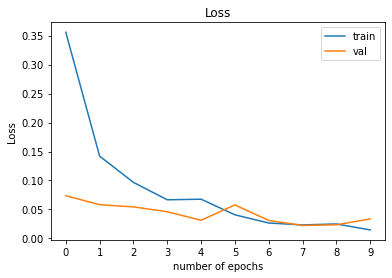

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    global epoch
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epoch, epoch + num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    preds.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            acc_dict[phase].append(epoch_acc)
            loss_dict[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    
    show_curves(acc_dict, loss_dict)


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

# Audio

In [12]:
full_audio_dataset = CustomImageAudioDataset(y_train, audio_dataset = audio_train_df)
train_loader, valid_loader = createLoaders(full_audio_dataset, batch_size = 64)

sample_target = next(iter(train_loader))[0]
print(sample_target.shape)

torch.Size([4, 104])


In [13]:
class MonReseau(nn.Module):
    def __init__(self):
        super(MonReseau, self).__init__()
        
        #self.linear1 = nn.Linear(104, 9)
        self.linear1 = nn.Linear(104, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 9)
        
      
    def forward(self, x):
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = self.linear3(x)
        return x

monreseau = MonReseau()
monreseau = monreseau.cuda()

In [14]:
optimizer = torch.optim.Adam(monreseau.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
epoch = 0

In [15]:
def evaluation(dataloader):
    monreseau.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(),targets.cuda()
            _, predicted = torch.max(monreseau(inputs),1)
            total += targets.size(0)
            correct += (predicted.squeeze() == targets).sum()
    return(float(correct/total))

In [16]:
epoch = 0

In [17]:
def train_audio(nbepochs = 10):
    global epoch
    for epoch in range(epoch, epoch + nbepochs):
        monreseau.train()
        print("epoch", epoch)
        for inputs, targets in train_loader:
            inputs, targets = inputs.cuda(),targets.type(torch.LongTensor).cuda()

            monreseau.zero_grad()
            mespredictions = monreseau(inputs)
            loss = criterion(mespredictions,targets) 

            loss.backward()
            optimizer.step()

        print(100*evaluation(valid_loader))
    epoch = epoch + 1
train_audio(nbepochs = 50)

epoch 0
85.03623604774475
epoch 1
86.95652484893799
epoch 2
90.03623723983765
epoch 3
91.19565486907959
epoch 4
90.36232233047485
epoch 5
88.94928097724915
epoch 6
91.81159734725952
epoch 7
91.77536368370056
epoch 8
90.36232233047485
epoch 9
91.34058356285095
epoch 10
90.97826480865479
epoch 11
92.31884479522705
epoch 12
92.10145473480225
epoch 13
91.44927859306335
epoch 14
92.13768243789673
epoch 15
92.42753982543945
epoch 16
92.21014976501465
epoch 17
90.68840742111206
epoch 18
92.10145473480225
epoch 19
92.53623485565186
epoch 20
92.89855360984802
epoch 21
91.92029237747192
epoch 22
91.59420728683472
epoch 23
91.5217399597168
epoch 24
91.05072617530823
epoch 25
91.88405871391296
epoch 26
92.17391610145569
epoch 27
91.55797362327576
epoch 28
91.19565486907959
epoch 29
91.99275970458984
epoch 30
92.93478727340698
epoch 31
93.07971596717834
epoch 32
91.6304349899292
epoch 33
92.21014976501465
epoch 34
91.15942120552063
epoch 35
92.31884479522705
epoch 36
91.37681722640991
epoch 37
91.8

# Multimodal

Dataloaders

In [18]:
# Create dataset
full_train_dataset = CustomImageAudioDataset(y_train, image_train_df,audio_train_df,)
trainloader, valloader = createLoaders(full_train_dataset)
dataloaders = {'train': trainloader, 'val':valloader}


sample = next(iter(trainloader))[2]
print(sample.shape)

sample_target = next(iter(valloader))[2]
print(sample.shape)

torch.Size([4])
torch.Size([4])


Class resnet

In [19]:
import torch
import torch.nn as nn
from torchvision.models.resnet import conv1x1, conv3x3, model_urls, load_state_dict_from_url, BasicBlock, Bottleneck


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # audio
        self.linear1 = nn.Linear(104, 512)
        self.linear2 = nn.Linear(512, 512)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
    
    def _del_fc(self):
        self.fc = None

    def _forward_impl(self, x, s):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        # audio
        s = F.leaky_relu(self.linear1(s))
        s = F.leaky_relu(self.linear2(s))
        x = x+s
        x = self.fc(x)
        
        return x

    def forward(self, x, s):
        return self._forward_impl(x,s)
    
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict, strict = False)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

Model and optimizer and scheduler

In [20]:
model_multi = resnet18(pretrained=True) # You need to enable internet

num_ftrs = model_multi.fc.in_features
model_multi.fc = nn.Linear(
    in_features = num_ftrs, 
    out_features = nbClass
)
model_multi = model_multi.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_multi.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

Train model

Epoch 0/19
----------
train Loss: 0.2715 Acc: 0.9179
val Loss: 0.0256 Acc: 0.9928

Epoch 1/19
----------
train Loss: 0.0620 Acc: 0.9804
val Loss: 0.0272 Acc: 0.9917

Epoch 2/19
----------
train Loss: 0.0522 Acc: 0.9834
val Loss: 0.0099 Acc: 0.9978

Epoch 3/19
----------
train Loss: 0.0406 Acc: 0.9888
val Loss: 0.0189 Acc: 0.9946

Epoch 4/19
----------
train Loss: 0.0216 Acc: 0.9933
val Loss: 0.0078 Acc: 0.9978

Epoch 5/19
----------
train Loss: 0.0305 Acc: 0.9910
val Loss: 0.0142 Acc: 0.9942

Epoch 6/19
----------
train Loss: 0.0244 Acc: 0.9925
val Loss: 0.0117 Acc: 0.9967

Epoch 7/19
----------
train Loss: 0.0154 Acc: 0.9957
val Loss: 0.0059 Acc: 0.9978

Epoch 8/19
----------
train Loss: 0.0071 Acc: 0.9977
val Loss: 0.0058 Acc: 0.9982

Epoch 9/19
----------
train Loss: 0.0048 Acc: 0.9986
val Loss: 0.0045 Acc: 0.9993

Epoch 10/19
----------
train Loss: 0.0044 Acc: 0.9986
val Loss: 0.0053 Acc: 0.9982

Epoch 11/19
----------
train Loss: 0.0069 Acc: 0.9979
val Loss: 0.0059 Acc: 0.9982

Ep

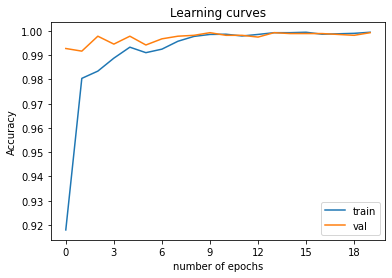

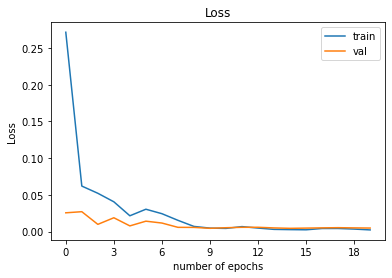

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for images, audio, labels in dataloaders[phase]:
                images = images.to(device)
                audio = audio.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images, audio).to(device)
                    _, preds = torch.max(outputs, 1)
                    preds.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            acc_dict[phase].append(epoch_acc)
            loss_dict[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    
    show_curves(acc_dict, loss_dict)


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_multi = train_model(model_multi, criterion, optimizer, scheduler, num_epochs=20)

# Submission creation

In [23]:
y_pred = []
y_placeholder = [0]*len(image_test_df)

test_dataset = CustomImageAudioDataset(y_placeholder,image_test_df, audio_test_df) # only inputs will be used in training
testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

for audio,images,_ in testloader:
    with torch.set_grad_enabled(False):
        outputs = model_multi(audio.to(device), images.to(device))
        _, prediction = torch.max(outputs, 1)
    
    y_pred.append(prediction.item())

# Submission file

In [24]:
submission = pd.DataFrame({'CLASS':y_pred})
submission=submission.reset_index()
submission = submission.rename(columns={'index': 'Id'})
submission.to_csv('first_submission.csv', index=False)